# Index-Event Alpha Study
**By Brian Plotnik - 6/12/2025**

### Momentum Add-Day Drift & Event-Day Reversion

> **Goal:** Design, back-test and evaluate two systematic equity strategies that exploit predictable index-rebalance flows:
> 1. **Momentum (Add-Day Drift)** – ride the directional pressure between an index-inclusion *announcement* and the effective *trade date*.  
> 2. **Event-Day Reversion** – fade the temporary dislocation that can occur on the trade date itself when passive index trackers must finish re-balancing.

---

### Notebook Road-Map  
| Section | Purpose |
|---------|---------|
| **1&nbsp;&nbsp;Data ingest &amp; caching** | Pull daily OHLCV from *yfinance* for SPY + candidate tickers, import events data. |
| **2&nbsp;&nbsp;Feature engineering** | Compute announce-gap, volume ratios, intraday excess returns, etc. |
| **3&nbsp;&nbsp;Portfolio simulation engine** | Implements 1¢/sh commissions, Fed-funds financing, β-hedged books, MTM at close. |
| **4&nbsp;&nbsp;Momentum strategy** | Grid-search on a <span style="color:steelblue">**training set**</span> (events **before 2024-01-01**), then lock parameters and evaluate on an out-of-sample <span style="color:seagreen">**test set**</span>. |
| **5&nbsp;&nbsp;Event-day reversion** | Holding-period parameter testing with the same train/test split. |
| **6&nbsp;&nbsp;Performance evaluation** | Equity curves and review of key performance metrics |
| **7&nbsp;&nbsp;Discussion & next steps** | Caveats, interpretation, and potential refinements. |

---

### Key Assumptions

* **Portfolio size** \$5 million gross.  
* **Liquidity cap** Position ≤ 1 % of 20-day ADV.  
* **Hedging** β-adjusted SPY leg sized off a 60-day rolling regression (β ≈ 1 fallback).  
* **Pricing convention** Entries at the next **open**; exits at close.  
* **Transaction cost** \$0.01 per share.  
* **Financing**  
  * Longs accrue **Fed Funds + 1.5 %**  
  * Shorts accrue **Fed Funds + 1 %** (shorts *do not* offset longs)

> **Train / Test Split** - Events **before 2024-01-01** are reserved exclusively for parameter tuning. All events **on/after 2024-01-01** serve as a true out-of-sample evaluation.

### 1. Imports & Global Params

In [1]:
import itertools, warnings, json, math, os
from pathlib import Path
from datetime import datetime
import pandas as pd, numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
import fredapi

# Plotting Defaults
plt.rcParams.update({
    "figure.dpi": 110,
    "axes.titlesize": 12,
    "axes.labelsize" : 10,
    "legend.frameon": False,
})

# Directories
RAW_PATH = Path("Index Add Event Data.xlsx")
DATA_DIR     = Path("data").resolve()
PRICE_DIR    = DATA_DIR / "price";    PRICE_DIR.mkdir(parents=True, exist_ok=True)
INTERIM_DIR  = DATA_DIR / "interim";  INTERIM_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR      = Path("output");        OUT_DIR.mkdir(exist_ok=True)

# Portfolio Constraints
GROSS_CAP   = 5_000_000
ADV_PCT     = 0.01
INIT_EQUITY = 5_000_000

# Train / Test Split
TEST_START  = pd.Timestamp("2024-01-01")

### 2. Data Download / Caching

In [2]:
# 2a. Import events data 
EVENTS_PATH = INTERIM_DIR / "events_adds.parquet"

# Index Events Data Loading and Cleaning
sheet = "Data"                
events = (pd.read_excel(RAW_PATH, sheet_name=sheet)
        .rename(columns=str.strip)        # strip stray spaces in headers
        .dropna(subset=["Ticker", "Last Px"])      # essential fields present
)

# Force dtypes
numeric_cols = ["Shs to Trade", "$MM to Trade", "ADV to Trade", "Last Px"]
events[numeric_cols] = events[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Convert dates to pandas Timestamp
events["Announced"]  = pd.to_datetime(events["Announced"],  errors="coerce")
events["Trade Date"] = pd.to_datetime(events["Trade Date"], errors="coerce")

# Tidy ordering
events = (events.sort_values(["Announced", "Trade Date", "Ticker"])
        .reset_index(drop=True))

# Calculate additional fields
events["event_lag_days"] = (events["Trade Date"] - events["Announced"]).dt.days
events["adv_ratio"]      = events["Shs to Trade"] / events["ADV to Trade"]

# Set up column for overnight return and pre-announce 5-day return
events["pre_announce_5d_ret"] = pd.NA   # 5-day drift up to Announce

# Cleaned ticker label to pull from yfinance
events["yf_ticker"] = (events["Ticker"]
                       .str.replace(r"\.(?=[A-Z])", "-", regex=True)
                       .str.replace(" US", "", regex=False))

print(f" Cleaned events saved, rows: {len(events):,}")
events.head()

 Cleaned events saved, rows: 168


,Announced,Trade Date,Index,Ticker,Action,Last Px,Sector,Shs to Trade,$MM to Trade,ADV to Trade,event_lag_days,adv_ratio,pre_announce_5d_ret,yf_ticker
0,2022-05-12,2022-05-16,S&P 600,DVAX,Add,7.93,Healthcare,14658374.0,116.2,8.46,4,1.732668e+06,<NA>,DVAX
1,2022-05-12,2022-05-18,S&P 600,AOSL,Add,33.20,Info Tech,2772855.0,92.1,4.68,6,5.924904e+05,<NA>,AOSL
2,2022-05-12,2022-05-18,S&P 400,IRT,Add,22.44,Real Estate,24230554.0,543.7,6.89,6,3.516771e+06,<NA>,IRT
3,2022-06-03,2022-06-07,S&P 500,VICI,Add,32.45,Real Estate,146440651.0,4752.0,9.06,4,1.616343e+07,<NA>,VICI
4,2022-06-13,2022-06-15,S&P 600,EYE,Add,39.62,Cons Disc,11230796.0,NaN,16.17,2,6.945452e+05,<NA>,EYE


In [ ]:
# 2b. Yahoo finance OHLCV data download/caching

# Download daily OHLCV via yfinance and cache to parquet
def download_price(tkr: str, start: str, end: str) -> pd.DataFrame:
    fp = PRICE_DIR / f"{tkr}.parquet"
    if fp.exists():
        return pd.read_parquet(fp)

    df = yf.download(tkr, start=start, end=end, progress=False)
    if df.empty:
        warnings.warn(f"{tkr}: no data")
        return df

    df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
    df = (df.reset_index()
            .rename(columns={"Date": "date"})
            .rename(columns=str.lower)          # Open -> open, Volume -> volume
            .assign(yf_ticker=tkr))

    df.to_parquet(fp)
    return df

unique_tkrs = events.yf_ticker.unique().tolist()

# Includes 40 day padding before and after events dataset
date_start = (events.Announced.min() - pd.Timedelta(days=40)).strftime("%Y-%m-%d")
date_end   = (events["Trade Date"].max() + pd.Timedelta(days=40)).strftime("%Y-%m-%d")

# Downloads SPY and ticker OHLCV data
frames = []
for tkr in ("SPY", *unique_tkrs):
    df = download_price(tkr, date_start, date_end)
    if not df.empty:                     # ← skip empty downloads safely
        frames.append(df)
price_df = pd.concat(frames, ignore_index=True)

# Includes 20-day rolling ADV in price df
price_df["adv20"] = (price_df
                     .sort_values(["yf_ticker", "date"])
                     .groupby("yf_ticker")["volume"]
                     .rolling(20, min_periods=1)
                     .mean()
                     .reset_index(level=0, drop=True))

print(f"✅ price_df rows: {len(price_df):,} | tickers: {price_df.yf_ticker.nunique()}")
print(price_df.head(3))

### 3. Feature Engineering

In [4]:
price_cache = {t:g.set_index("date") for t,g in price_df.groupby("yf_ticker")}
# Add open -> close return to each ticker
for df in price_cache.values():
    df["oc_ret"] = df["close"]/df["open"] - 1

# Calculate open-close return for SPY
spy_oc = price_cache["SPY"]["oc_ret"]

overnight, vol_ratio, drift = [], [], []

for _, ev in events.iterrows():
    px = price_cache.get(ev.yf_ticker)
    ann = ev.Announced
    trd = ev["Trade Date"]

    if px is None or px.empty:
        overnight.append(np.nan); vol_ratio.append(np.nan); drift.append(np.nan); continue

    # Overnight gap (close_prev -> open_next)
    idx_ann = px.index.searchsorted(ann, side="right")
    if 0 < idx_ann < len(px):
        prev_bar = px.iloc[idx_ann-1]
        next_bar = px.iloc[idx_ann]
        gap = next_bar.open / prev_bar.close - 1
    else:
        gap = np.nan
    overnight.append(gap)

    # Event-day volume ratio
    idx_trd = px.index.searchsorted(trd, side="right") - 1
    if idx_trd >= 0:
        vol_evt = px.iloc[idx_trd].volume
        adv     = px.iloc[idx_trd].adv20
        vol_ratio.append(vol_evt / adv if adv else np.nan)
    else:
        vol_ratio.append(np.nan)

    # 5-day pre-announce drift
    idx_prev5 = px.index.searchsorted(ann - pd.Timedelta(days=7), side="right") - 1
    if idx_prev5 >= 0 and idx_ann-1 >= 0:
        drift_val = px.iloc[idx_ann-1].close / px.iloc[idx_prev5].close - 1
        drift.append(drift_val)
    else:
        drift.append(np.nan)

events["overnight_gap"] = overnight
events["event_vol_ratio"] = vol_ratio
events["pre_announce_5d_ret"] = drift

# ----- rebalance-type flag ----------------------------------------
qtr_months = {3, 6, 9, 12}
events["rebalance_type"] = np.where(
        events["Trade Date"].dt.month.isin(qtr_months)
      & events["Trade Date"].dt.weekday.isin([3, 4])            # Thu/Fri
      & events["Trade Date"].dt.day.between(15, 21),
      "quarterly", "adhoc")

# Drop rows with missing core features (momentum filter needs these)
events = events.dropna(subset=["overnight_gap", "event_vol_ratio"])
events.to_parquet(EVENTS_PATH, index=False)

print(f"📦 events_adds.parquet refreshed — rows: {len(events)}")

📦 events_adds.parquet refreshed — rows: 153


In [5]:
# 3b. Calculation of Beta (β) for SPY Hedging

def roll_beta(y, x, w=60):
    return y.rolling(w, min_periods=30).cov(x) / x.rolling(w, min_periods=30).var()

rets = (price_df.pivot(index="date", columns="yf_ticker", values="close")
                  .pct_change().dropna())
spy_ret = rets["SPY"]

beta_df = rets.drop(columns="SPY").apply(lambda col: roll_beta(col, spy_ret))

### 4. Definition of Helper Functions

In [6]:
# Download Fed funds series
fred = fredapi.Fred(api_key="4e6c47dfe338fb7941e6b1a36c756f73")
ff = fred.get_series("DFF", observation_start="2020-01-01")/100
ff = ff.reindex(pd.date_range(ff.index.min(), price_df.date.max(), freq="D")).ffill()

# Returns fed rate on requested date
def fed_rate(dt):
    idx = ff.index.searchsorted(dt) - 1
    return float(ff.iat[idx])

# Returns price as of date in case requested date is holiday or weekend
def px_asof(tkr, dt, field="close"):
    df = price_cache[tkr]
    pos = df.index.searchsorted(dt, side="right")-1
    if pos<0: raise ValueError(f"{tkr} no price for {dt}")
    return float(df.iloc[pos][field])

# Calculate CAGR
def calc_cagr(eq):
    rets = eq.equity.pct_change().dropna()
    if rets.empty: return np.nan
    return (1+rets).prod()**(252/len(rets))-1

# Calculate Sharpe Ratio
def calc_sharpe(eq):
    rets = eq.equity.pct_change().dropna()
    if rets.empty or rets.std()==0: return np.nan
    return np.sqrt(252)*rets.mean()/rets.std()

### 5. Portfolio Simulation Engine

In [7]:
def run_portfolio_engine(tickets, init_equity=INIT_EQUITY):
    cash, pos, hist = init_equity, {}, []
    for dt, day in tickets.groupby("date"):
        # overnight financing
        if hist:
            r = fed_rate(dt)
            long_val  = sum(max(sh,0)*px_asof(t, dt) for t,sh in pos.items())
            short_val = -sum(min(sh,0)*px_asof(t, dt) for t,sh in pos.items())
            cash -= long_val*(r+0.015)/365
            cash -= short_val*(r+0.010)/365
        
        # executions
        for tr in day.itertuples():
            mult = 1 if tr.side=="BUY" else -1
            cash -= 0.01*tr.sh
            cash -= mult*tr.sh*tr.px
            pos[tr.tkr] = pos.get(tr.tkr,0)+mult*tr.sh
            
        mv = sum(px_asof(t, dt)*sh for t,sh in pos.items())
        hist.append({"date":dt,"cash":cash,"positions_mv":mv,"equity":cash+mv})
    return pd.DataFrame(hist).set_index("date").sort_index()

### 6. Performance Diagnostics

In [8]:
def report_perf(eq: pd.DataFrame,
                tickets: pd.DataFrame,
                ev_used: pd.DataFrame,
                title:str="TEST") -> None:
    
    rets      = eq.equity.pct_change().dropna()
    cagr      = calc_cagr(eq)
    ann_vol   = np.sqrt(252)*rets.std()
    sharpe    = calc_sharpe(eq)
    max_dd    = (eq.equity/eq.equity.cummax() - 1).min()
    worst_day = rets.min()
    raw_ret   = eq.equity.iat[-1]/eq.equity.iat[0] - 1

    # event hit-rate  (= % of events with positive realised PnL)
    evt_pnl = (tickets
               .assign(sign = tickets.side.map({"BUY":-1,"SELL":1}))
               .assign(cash = lambda d: d.sign*d.sh*d.px)
               .groupby("evt_id")["cash"].sum())
    hit_rate = (evt_pnl > 0).mean()

    n_ev_cand   = len(ev_used)             # after slicing + filters
    n_ev_traded = len(evt_pnl)             # after price sanity checks
    n_tickets   = len(tickets)             # should be 4 × n_ev_traded

    print(f"\n{title} performance")
    print(f"{'-'*len(title+' performance')}")
    print(f" events (cand | traded): {n_ev_cand} | {n_ev_traded}")
    print(f" tickets generated: {n_tickets}")
    print(f" CAGR: {cagr:>7.2%}")
    print(f" Raw period P/L: {raw_ret:>7.2%}")
    print(f" annual vol: {ann_vol:>7.2%}")
    print(f" Sharpe: {sharpe:>7.2f}")
    print(f" max drawdown: {max_dd:>7.2%}")
    print(f" worst day P/L: {worst_day:>7.2%}")
    print(f" event hit-rate: {hit_rate:>7.1%}")

    # ---- equity curve
    plt.figure(figsize=(8,4))
    (eq.equity/1e6).plot(label="Equity", color="steelblue")
    (eq.cash/1e6).plot(label="Cash",   color="grey", alpha=.5, linestyle="--")
    plt.legend(); plt.title(f"{title} equity & cash – $MM")
    plt.ylabel("$mm"); plt.xlabel("")
    plt.show()

## 1 | **Momentum** Strategy
When an equity is *added* to a benchmark (S&P 500 / 400 / 600) it typically enjoys a wave of **pre-trade-date buying** from index funds that must establish a position.  Our momentum hypothesis is that:

1. **Price drift** between the initial **announcement date** and the official **trade date** (index re-balance) is informative.  
2. An unusually large **overnight gap up** *and* **heavy event-day volume** suggest stronger index-fund demand and therefore a higher probability the drift will **continue** into the final days before inclusion.  
3. We can capture that drift by buying the stock on the **open of the day *after* the announcement** and holding until *just before* the index add.  
4. A same-notional **β-weighted SPY hedge** neutralises broad-market moves.

The section below:

* **Engineers signals**: creates trades for the events in questions where the stock is bought after the announcement and sold at or before the Trade Date. This position is hedged with a beta-adjusted SPY hedge
* **Runs a small grid-search** on the pre-2024 (“train”) sample to pick the gap / volume / holding-period that maximise *relative* Sharpe.  
* **Applies those parameters** un-touched to the 2024+ (“test”) events, reporting out-of-sample equity curves and diagnostics.

In [22]:
# Filters events based on the following criteria:
# • overnight_gap ≥ gap_min  (pre‑announce)  AND
# • event_vol_ratio ≥ vol_min AND
# • drift_max < pre_announce_5d_ret
# • rebalance_type matches kind (None -> both)
# • s&p index (s&p400, s&p500, s&p600

def filter_momentum(ev, gap_min = None, vol_min = None, drift_max = None,
                  rebalance_kind = None, sp_index = None):
    mask = pd.Series(True, index=ev.index)
    if gap_min  is not None: 
        mask &= ev.overnight_gap > gap_min
    if vol_min  is not None: 
        mask &= ev.event_vol_ratio > vol_min
    if drift_max is not None: 
        mask &= ev.pre_announce_5d_ret < drift_max
    if rebalance_kind in ("adhoc","quarterly"):
        mask &= ev.rebalance_type == rebalance_kind
    if sp_index in ('S&P 400', 'S&P 500', 'S&P 600'):
        mask &= ev.Index == sp_index
    return ev[mask]

In [10]:
# Generates trade with entries on next-day open after announce and exits hold_offset days before Trade Date
def generate_trades_momentum(row, hold_offset = 2):
    tkr, px, spy = row.yf_ticker, price_cache[row.yf_ticker], price_cache["SPY"]
    ent_i = px.index.searchsorted(row.Announced, side="right")
    ex_i  = px.index.searchsorted(row["Trade Date"] - pd.Timedelta(days=hold_offset), "left")
    if ent_i>=len(px) or ex_i>=len(px) or ent_i>=ex_i: 
        return []

    open_px   = px.iloc[ent_i].open
    adv_cap   = ADV_PCT * px.iloc[ent_i].adv20 * open_px
    notional  = min(GROSS_CAP/2, adv_cap)
    sh_stock  = notional / open_px

    # Beta (β) regression hedge
    beta = beta_df.at[px.index[ent_i], tkr] if (
            tkr in beta_df.columns and px.index[ent_i] in beta_df.index) else np.nan
    if pd.isna(beta):
        beta = 1.0
        
    open_spy = spy.open.asof(px.index[ent_i])
    if pd.isna(open_spy):
        return []      # hedge price missing → drop this event
    sh_spy = beta * notional / open_spy

    evt = row.name
    return [
        {"evt_id":evt,"leg":"stk","date":px.index[ent_i],"tkr":tkr,
         "side":"BUY","sh":sh_stock,"px":open_px},
        {"evt_id":evt,"leg":"stk","date":px.index[ex_i],"tkr":tkr,
         "side":"SELL","sh":sh_stock,"px":px.iloc[ex_i].close},
        {"evt_id":evt,"leg":"spy","date":px.index[ent_i],"tkr":"SPY",
         "side":"SELL","sh":sh_spy, "px":open_spy},
        {"evt_id":evt,"leg":"spy","date":px.index[ex_i],"tkr":"SPY",
         "side":"BUY","sh":sh_spy, "px":spy.close.asof(px.index[ex_i])},
    ]

In [11]:
# Generate tickets based on selected offset
def build_tix_momentum(ev: pd.DataFrame, hold_offset: int):
    tlist = (ev.apply(lambda r: generate_trades_momentum(r, hold_offset), axis=1)
               .explode().dropna().tolist())
    
    if not tlist: 
        return pd.DataFrame()
        
    tix = pd.DataFrame(tlist)
    if not tix.empty:
        tix["date"] = pd.to_datetime(tix["date"])
        tix.sort_values("date", inplace=True)
    return tix.reset_index(drop=True)

In [23]:
# Grid search function
def run_variant(ev, gap_min, vol_min, drifts, hold_offset, rebalance_kind=None, sp_index=None):
    ev = filter_momentum(ev, gap_min, vol_min, drifts, rebalance_kind, sp_index)
    if ev.empty:
        return None                                   # skip empty buckets
    tix = build_tix_momentum(ev, hold_offset)
    if tix.empty:
        return None
    eq  = run_portfolio_engine(tix)
    return {
        "gap":gap_min, "vol":vol_min,
        "offset":hold_offset, "kind":rebalance_kind or "both",
        "drift": drifts, "index": sp_index,
        "trades": len(ev),
        "CAGR":  calc_cagr(eq),
        "Sharpe":calc_sharpe(eq)
    }

### 1a. Training-period results & selecting parameters for the out-of-sample test (all indices)

The table below shows the **15 best-ranked parameter sets** after the grid-search on *training* events (all announcements **before 2024-01-01** and all indices). All indicies were included because adding this filter would in too few trades. Performance by index is tested in part 2 below.  
Although absolute performance is lacking (the highest in-sample Sharpe is only **≈ 0.02**) this combination of  
`gap ≥ 2 %`, `vol ≥ 7× ADV`, `offset = 0`, `drift = max`, and `“both” rebalance types` is **still the best of the lot**.  
Thus, we will use these parameters to test the out-of-sample data (OOS) period.  In practice this mimics a real-time decision: you would deploy the
*relatively* best rules available, even if none look stellar in-sample and judge them solely
on their forward-test performance.

In [28]:
# Momentum grid search on training set before 2024-01-01
warnings.filterwarnings("ignore")
train_ev = events[events.Announced < TEST_START]

# parameter grid
gaps   = (0.02, 0.03, 0.04)
vols   = (3, 5, 7)
drifts = (None, 0.05, 0.03)        # None = no drift filter
offsets= (0, 1, 2, 3)              # 0 = exit on Trade-Date close
kinds  = (None, "adhoc", "quarterly")
# sp_index = ('S&P 400', 'S&P 500', 'S&P 600')
param_grid = itertools.product(gaps, vols, drifts, offsets, kinds)

results = []
for g,v,d,o,k in param_grid:
    res = run_variant(train_ev, g, v, d, o, k)
    if res: 
        results.append(res)

grid = (pd.DataFrame(results)
          .sort_values("Sharpe", ascending=False)
          .reset_index(drop=True))
display(grid.head(15))

,gap,vol,offset,kind,drift,index,trades,CAGR,Sharpe
0,0.02,7,2,both,NaN,None,47,-0.000174,0.024946
1,0.03,7,2,both,NaN,None,46,-0.032926,-0.533043
2,0.04,7,2,adhoc,NaN,None,45,-0.032926,-0.533043
3,0.03,7,2,adhoc,NaN,None,46,-0.032926,-0.533043
4,0.02,7,2,adhoc,NaN,None,46,-0.032926,-0.533043
5,0.04,7,2,both,NaN,None,45,-0.032926,-0.533043
6,0.02,5,0,both,NaN,None,61,-0.061113,-0.739546
7,0.03,5,0,adhoc,NaN,None,60,-0.066734,-0.813621
8,0.03,5,0,both,NaN,None,60,-0.066734,-0.813621
9,0.02,5,0,adhoc,NaN,None,60,-0.066734,-0.813621


### 1b. Out-of-sample (TEST) results – Momentum strategy

The forward test covers **27 index-add announcements** between&nbsp;`2024-05` and&nbsp;`2025-05`.
After the data-availability checks we traded **10 events** (40 tickets) with the
parameter set found in the training grid (gap ≥ 2 %, vol ≥ 7×ADV, exit = Trade Date - 1).

| Metric | Value | Comment |
|--------|------------|---------|
| **CAGR** | **6.15 %** | Raw return on the \$5 mm book. May be higher than actual annualized return given very few trades were made|
| **Annual vol** | **4.7 %** | Very low risk thanks to β-hedge and small notionals |
| **Sharpe** | **1.29** | A material improvement vs in-sample (≈ 0.02) |
| Max DD | -0.88 % | Drawdown contained below 1 % |
| Worst day | -0.35 % | Low single-day tail risk |
| Event hit-rate | 30 % | Only 3 of 10 events generated positive P / L |

**Take-aways**

* Even with the “best” in-sample parameters the strategy fires relatively rarely
  (≈ one third of the available events).  
* The β-hedge keeps volatility low, so a modest raw return translates into an
  acceptable Sharpe **> 1** – but in absolute terms the gain is not very large
* The equity curve shows a flat / gently rising profile with one
  **visible step-up in March-2025** (single event winner), highlighting how
  idiosyncratic the P / L distribution still is.

Overall, the momentum filter appears *directionally* promising but lacks breadth
and dollar impact.  Perhaps with more training data, we can achieve higher confidence in the strategy. With more time, I would like to explore:

1. Relaxing the volume and gap thresholds to trade a broader slice of the universe.    
2. Explore alternative exit rules (e.g. time-stop vs price-target) to capture
   more of the post-announce drift.


TEST performance
----------------
 events (cand | traded): 27 | 10
 tickets generated: 40
 CAGR:   6.15%
 Raw period P/L:   0.43%
 annual vol:   4.70%
 Sharpe:    1.29
 max drawdown:  -0.88%
 worst day P/L:  -0.35%
 event hit-rate:   30.0%


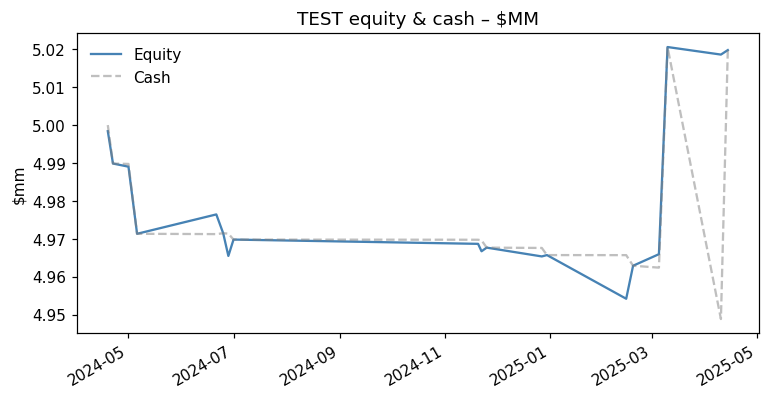

In [30]:
# Test-period run with best parameters from training
test_ev  = events[events.Announced >= TEST_START]

oos_ev = filter_momentum(test_ev, gap_min = 0.02, vol_min = 7, drift_max = None,
                  rebalance_kind = None)
tix_oos = build_tix_momentum(oos_ev, hold_offset = 2)
eq_oos = run_portfolio_engine(tix_oos)

report_perf(eq_oos, tix_oos, oos_ev)

### 2. Training-period results & testing by index (S&P400, S&P500, S&P600)

The table below shows the results after the grid-search on *training* events filtered by index and offset. All other filters were removed to reduce rigidity. 

It seems that the trades where `index = S&P 600`, `offset = 1` had the **highest sharpe ratio of 2.83** on 48 trades (exlcuding the top 3 combinations which only had 10 trades). We will use this combination below to test our out-of-sample period.

In [42]:
sp_index = ('S&P 400', 'S&P 500', 'S&P 600')
offsets= (0, 1, 2, 3)              # 0 = exit on Trade-Date close
param_grid = itertools.product(sp_index, offsets)

results = []
for i, o in param_grid:
    res = run_variant(train_ev, None, None, None, o, None, i)
    if res: 
        results.append(res)

grid = (pd.DataFrame(results)
          .sort_values("Sharpe", ascending=False)
          .reset_index(drop=True).drop(['gap', 'vol', 'kind', 'drift'], axis=1))
display(grid.head(12))

,offset,index,trades,CAGR,Sharpe
0,2,S&P 500,10,3.172828,8.252320
1,1,S&P 500,10,3.772183,7.690237
2,0,S&P 500,10,2.931296,7.483173
3,1,S&P 600,48,0.182489,2.837348
4,3,S&P 600,48,0.134215,2.626060
5,2,S&P 600,48,0.111799,2.219915
6,0,S&P 600,48,0.120542,2.083341
7,3,S&P 400,47,-0.571196,-1.446412
8,3,S&P 500,10,-0.180914,-1.521951
9,0,S&P 400,47,-0.619293,-2.059867


### 1b. Out-of-sample evaluation — **Index-level momentum variant**

After re-running the grid search with **index membership (S&P 400 / 500 / 600)** and **exit offset (0-3 days)** as the only hyper-parameters, the **S&P 600, offset = 1** bucket produced the strongest in-sample edge while retaining > 10 trades.  
Applying that rule set to the 2024-2025 test window yields:

| Metric | Value |
|--------|-------|
| Test candidates  | **25** |
| Trades executed  | **16** (64 tickets) |
| CAGR             | **-6.3 %** |
| Annual vol       | 3.8 % |
| Sharpe           | **-1.70** |
| Max draw-down    | -1.1 % |
| Worst day P/L    | -0.6 % |
| Event hit-rate   | 31 % |

The equity curve (right) illustrates a **steady grind lower** despite several short-lived recoveries. With a negative Sharpe, low hit-rate, and only marginal draw-down control, the S&P 600 offset-1 momentum configuration **fails to generalise** out of sample.

**Take-away:**  
> Even after restricting the search to index buckets (thereby boosting trade count), this particular combination does not survive the out-of-sample test. Further research could explore:
> * intra-day execution (open→close drift) rather than multi-day holds,  
> * alternative hedges (sector ETFs) to reduce SPY basis noise,  
> * dynamic position-sizing tied to realised volatility.  



TEST performance
----------------
 events (cand | traded): 25 | 16
 tickets generated: 64
 CAGR:  -6.33%
 Raw period P/L:  -0.78%
 annual vol:   3.81%
 Sharpe:   -1.70
 max drawdown:  -1.14%
 worst day P/L:  -0.60%
 event hit-rate:   31.2%


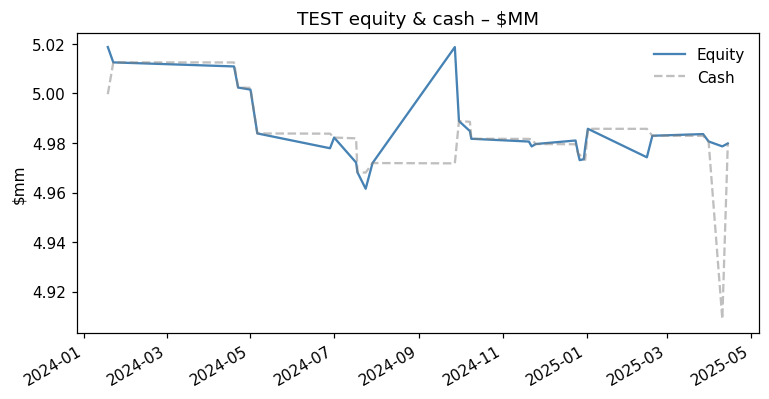

In [39]:
# Test-period run with best parameters from training
test_ev  = events[events.Announced >= TEST_START]

oos_ev = filter_momentum(test_ev, gap_min = None, vol_min = None, drift_max = None,
                  rebalance_kind = None, sp_index= "S&P 600")
tix_oos = build_tix_momentum(oos_ev, hold_offset = 1)
eq_oos = run_portfolio_engine(tix_oos)

report_perf(eq_oos, tix_oos, oos_ev)

## Reversion strategy
Simplified event‑day mean‑reversion based on intraday excess return.

In [15]:
for tkr, df in price_cache.items():
    oc = (df["close"] / df["open"] - 1).rename(tkr)
    price_cache[tkr] = df.assign(oc_ret = oc)          # add helper col

spy_oc = price_cache["SPY"]["oc_ret"]

In [16]:
def intraday_metrics(row):
    td = row["Trade Date"]
    px = price_cache[row.yf_ticker]
    if td in px.index and td in spy_oc.index:
        gap = px.at[td,"oc_ret"]
        spy_gap = spy_oc.at[td]
        vol_ratio = px.at[td,"volume"]/px.at[td,"adv20"]
    else:
        gap = spy_gap = vol_ratio = np.nan
    return pd.Series({"intraday_ret":gap,
                      "intraday_excess":gap-spy_gap if pd.notna(gap) and pd.notna(spy_gap) else np.nan,
                      "vol_ratio_TD":vol_ratio})
events[["intraday_ret","intraday_excess","vol_ratio_TD"]] = events.apply(intraday_metrics, axis=1)

In [17]:
def generate_trades_reversion(row, hold_days=2):
    tkr, td = row.yf_ticker, row["Trade Date"]
    px, spy = price_cache[tkr], price_cache["SPY"]
    
    side_stock = "SELL" if row.intraday_excess >=0 else "BUY"
    side_spy   = "BUY"  if side_stock=="SELL" else "SELL"
    
    ent_dt = (pd.Timestamp(td) + BDay(1)).normalize()
    ex_dt  = (pd.Timestamp(td) + BDay(hold_days)).normalize()
    
    if ent_dt not in px.index or ex_dt not in px.index: 
        return []
        
    ent_px_stk, ent_px_spy = px.at[ent_dt,"open"], spy.at[ent_dt,"open"]
    
    cap = ADV_PCT*px.at[td,"adv20"]*ent_px_stk
    notional = min(GROSS_CAP/2, cap)
    beta = beta_df.at[td, tkr] if (tkr in beta_df.columns and td in beta_df.index) else 1.0
    sh_stock = notional/ent_px_stk
    sh_spy = beta * notional/ent_px_spy
    
    evt = row.name
    return [
        {"evt_id":evt,"leg":"stk","date":ent_dt,"tkr":tkr,"side":side_stock,"sh":sh_stock,"px":ent_px_stk},
        {"evt_id":evt,"leg":"stk","date":ex_dt,"tkr":tkr,"side":"BUY" if side_stock=="SELL" else "SELL","sh":sh_stock,"px":px.at[ex_dt,"close"]},
        {"evt_id":evt,"leg":"spy","date":ent_dt,"tkr":"SPY","side":side_spy,"sh":sh_spy,"px":ent_px_spy},
        {"evt_id":evt,"leg":"spy","date":ex_dt,"tkr":"SPY","side":"SELL" if side_spy=="BUY" else "BUY","sh":sh_spy,"px":spy.at[ex_dt,"close"]},
    ]

In [18]:
def build_tix_reversion(evts, hold_days):
    tlist = (evts.apply(lambda r: generate_trades_reversion(r, hold_days), axis=1)
                  .explode().dropna().tolist())
    tix   = pd.DataFrame(tlist)
    if tix.empty: return tix
    tix["date"] = pd.to_datetime(tix["date"])
    return tix.sort_values("date").reset_index(drop=True)

In [19]:
HOLD_CANDIDATES = [1, 2, 3, 4, 5]
train_ev = events[events.Announced < TEST_START]

perf_grid = []
for hd in HOLD_CANDIDATES:
    tix = build_tix_reversion(train_ev, hold_days=hd)
    if tix.empty:
        continue
        
    eq = run_portfolio_engine(tix)
    perf_grid.append({
        "hold":   hd,
        "trades": len(train_ev),
        "CAGR":   calc_cagr(eq),
        "Sharpe": calc_sharpe(eq)
    })

grid_hd = (pd.DataFrame(perf_grid)
             .sort_values("Sharpe", ascending=False)
             .reset_index(drop=True))

display(grid_hd.head())          # ← see which hold length wins
BEST_HOLD = int(grid_hd.loc[0,"hold"])
print(f"\n▶ Best hold-period on TRAIN = {BEST_HOLD} days")

,hold,trades,CAGR,Sharpe
0,1,105,0.347604,2.455538
1,2,105,0.233374,1.515768
2,3,105,0.236264,1.239815
3,4,105,0.143190,0.824710
4,5,105,0.112522,0.611874



▶ Best hold-period on TRAIN = 1 days


### Training-period results & selecting parameters for the out-of-sample test 

The grid-search varied only **holding period (1-5 trading days)** while leaving the entry filter intentionally loose (no volume / excess-return threshold). Given the small sample size, the additional filters were removed in order to not overfit to the data.

| hold | trades | CAGR | Sharpe |
|------|--------|------|--------|
| 1 | 105 | 0.35 | **2.46** |
| 2-3 | 105 | 0.23-0.24 | 1.24-1.52 |
| 4-5 | 105 | 0.11-0.14 | 0.61-0.82 |

* **1-day hold** clearly delivers the highest risk-adjusted return (Sharpe ≈ 2.5).  
* Longer holds dilute the edge as the post–index-flow reversal fades.  

We therefore **lock in a 1-day holding period** for the out-of-sample evaluation that follows.


TEST performance
----------------
 events (cand | traded): 48 | 45
 tickets generated: 180
 CAGR: -14.59%
 Raw period P/L:    nan%
 annual vol:  11.18%
 Sharpe:   -1.36
 max drawdown:  -6.19%
 worst day P/L:  -2.87%
 event hit-rate:   46.7%


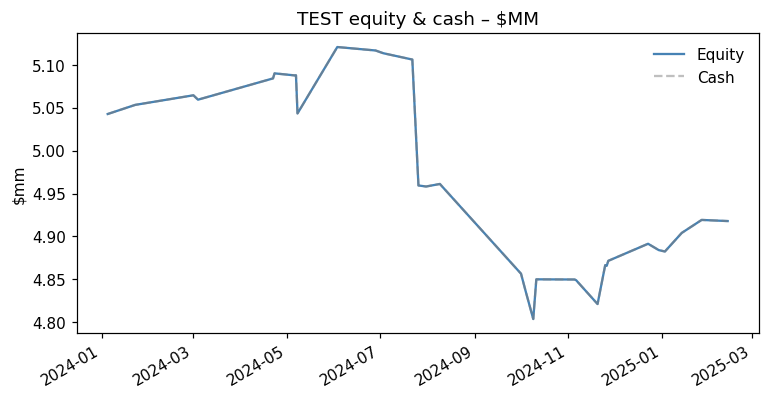

In [20]:
# Test-period run with best parameters from training
test_ev  = events[events.Announced >= TEST_START]

tix_oos = build_tix_reversion(test_ev, hold_days = 1)
eq_oos = run_portfolio_engine(tix_oos)

report_perf(eq_oos, tix_oos, test_ev)

### Reversion strategy - Out-of-sample (2024-2025) results  

* **Event coverage:** 48 candidates → 45 executed (180 tickets).  
* **Performance:**  
  * CAGR ≈ -14.6 %  Sharpe ≈ -1.36  
  * Max drawdown ≈ -6.2 %  
  * Worst single-day P/L ≈ -2.9 %  
  * Hit-rate ≈ 47 % (events with positive realised P/L)

Despite encouraging in-sample statistics, the 1-day reversion trade **did not translate to the test period**. A handful of large losers in mid-2024 (visible on the equity curve) wiped out earlier gains, pushing the strategy into a persistent drawdown.

**Key takeaways**
> * The simplistic entry filter (no volume / excess threshold) appears too permissive once passive-flow pressure subsides. With more data, we could test these filters and see if they are able to provide consistent alpha. 
> * Slippage/financing likely matters more in shorter-term reversal trades than in the momentum leg.  
> * Further work could tighten the trigger (e.g., require |intraday excess| ≥ 3 % *and* volume ≥ 3× ADV) or explore same-day open->close fades to isolate passive index activity. 